In [ ]:

import re
import keras
import pandas as pd
import numpy as np
from itertools import compress

import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import f1_score, classification_report, accuracy_score
from datetime import datetime


from keras.models import Model
from keras.layers import Dense, LSTM, Embedding, Dropout, Input
from keras.layers import concatenate



In [2]:
'''
utils functions
'''
def stemmer(doc):
    sb_stemmer = SnowballStemmer('english')
    stemmed_doc = ' '.join([sb_stemmer.stem(x) for x in doc.split()])
    return stemmed_doc



def clean_tweets(tweets):
    
    # replace all urls with a URL token
    url_removed = [re.sub(r"http[s]?:\/{2}[^\s]*", ' URL ', x) for x in tweets]
    url_removed = [re.sub(r"pic.twitter.com\/\w*", ' URL ', x) for x in url_removed]
    
    # replace usernames : replace tokens beginning with '@' with USERNAME token
    username_removed = [re.sub(r"@\w*", ' USERNAME ', x) for x in url_removed]
    
    #replace slang with SLANG token
    slang_removed = [re.sub(r"\$\&\@\*\#", ' SLANG ', x) for x in username_removed]
    
    # get all hashtags from the tweets
    _hashtags = [re.findall(r"\#\w*", x) for x in slang_removed]
    _hashtags = [[tag[1:] for tag in sample] for sample in _hashtags]
    
    # remove all hashtags from the tweets
    hashtags_removed = [re.sub(r"\#\w*", '', x) for x in slang_removed]
    
    # strip whitespaces
    stripped_tweets = [' '.join(x.split()) for x in hashtags_removed]
    
    stemmed_tweets = [stemmer(x) for x in stripped_tweets]
    hashtags = [' '.join([x for x in sample]) for sample in _hashtags]
    
    return stemmed_tweets, hashtags



def get_hashtags_features(train_hashtags, test_hashtags, num_words=3500):

    # fit tokenizer on train hashtags
    HT_tokenizer = Tokenizer(num_words=3500, oov_token='UNK')
    HT_tokenizer.fit_on_texts(train_hashtags)
    
    #transform train & test hashtags to matrices
    train_HT_features = HT_tokenizer.texts_to_matrix(train_hashtags, mode='count')
    test_HT_features = HT_tokenizer.texts_to_matrix(test_hashtags, mode='count')
    
    return train_HT_features, test_HT_features

def get_sequence_features(train_cleaned_tweets, test_cleaned_tweets, vocab_size=5000, mode='tfidf'):
    # fit tokenizer on train sequences
    seq_tokenizer = Tokenizer(num_words=vocab_size, oov_token='UNK')
    seq_tokenizer.fit_on_texts(train_cleaned_tweets)
    
    #transform train & test sequences to matrices
    train_seq_features = seq_tokenizer.texts_to_matrix(train_cleaned_tweets, mode=mode)
    test_seq_features = seq_tokenizer.texts_to_matrix(test_cleaned_tweets, mode=mode)
    
    return train_seq_features, test_seq_features


def get_sequence_features_DL(train_cleaned_tweets, test_cleaned_tweets, vocab_size=5000, max_len_seq=30):

    # fit tokenizer on train sequences
    seq_tokenizer = Tokenizer(num_words=vocab_size, oov_token='UNK')
    seq_tokenizer.fit_on_texts(train_cleaned_tweets)

    # transform train & test sequences
    train_sequences = seq_tokenizer.texts_to_sequences(train_cleaned_tweets)
    test_sequences = seq_tokenizer.texts_to_sequences(test_cleaned_tweets)
    
    #padd train & test sequences
    padded_train_sequences = sequence.pad_sequences(train_sequences, maxlen = max_len_seq)
    padded_test_sequences = sequence.pad_sequences(test_sequences, maxlen = max_len_seq)
   
    return padded_train_sequences, padded_test_sequences

def hypertune_threshold(pred_prob, y_val, graph=False):
    f1_scores = {}
    accuracy = {}
    T = [0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65]
    for t in T:
        predictions=[]
        for i in pred_prob:
            if(i[1] > t):
                predictions.append(1)
            else:
                predictions.append(0)
        predictions = np.array(predictions)
        accuracy[t] = 1 - (predictions - y_val).abs().sum() / predictions.shape[0]
        print("F1 score with threshold =",t,"\t : ", f1_score(y_val, predictions))
        f1_scores[t] = f1_score(y_val, predictions)
    
    y1 = list(f1_scores.values())
    y2 = list(accuracy.values())
    max_T = T[np.argmax(y1)]
    max_F1 = fscores[max_T]
    accu = accuracy[max_T]
    if (graph):
        plt.plot(T, y1, label='F1 Score')
        plt.plot(T,y2, label='Accuracy')
        plt.legend()
        plt.show()
    return max_T, max_F1, accu

def get_submission_csv(y_preds):
    IDs = list(range(7921,9874))
    res = pd.DataFrame({'id':IDs, 'label':y_preds})
    filename = "submission_" + datetime.now().strftime("%d-%m-%Y_%H:%M:%S") + ".csv"
    res.to_csv(filename, index=False)
    


In [3]:
'''
get data
extract features
'''

train_data = pd.read_csv('./data/train_2kmZucJ.csv')
test_data = pd.read_csv('./data/test_oJQbWVk.csv')

train_tweets = train_data.tweet
train_labels = train_data.label
train_labels_cat = keras.utils.to_categorical(train_data.label)

test_tweets = test_data.tweet

train_cleaned_tweets, train_hashtags = clean_tweets(train_tweets)
test_cleaned_tweets, test_hashtags = clean_tweets(test_tweets)

```
Lets have a look at the data:
```

In [4]:
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


```
Lots of hashtags, usernames, and mis-spelt words.  
Data Cleaning applied:  
 - all urls were replaces with the [url] token
 - all usernames, starting with '@' were replaced with [username] token
 - all slangs were replaces with [slang] token
 - all hashtags were extracted and seperated
 - the rest of the text is stemmed and lower-cased
 
The tweets after the data cleaning steps looks like this:
```

Original Tweet : 	 @MiissToriix overrated waste of money :O that Will get me some abuse lol
Original Label : 	 1
Extracted Hashtags : 	 
Preprocessed Tweet : 	 usernam overr wast of money :o that will get me some abus lol

Original Tweet : 	 Thanks @O2 for my delivery today. Pre order paid of and beat my brother who pre ordered his of apple #iPhoneX pic.twitter.com/yVopwgPesb
Original Label : 	 0
Extracted Hashtags : 	 iPhoneX
Preprocessed Tweet : 	 thank usernam for my deliveri today. pre order paid of and beat my brother who pre order his of appl url



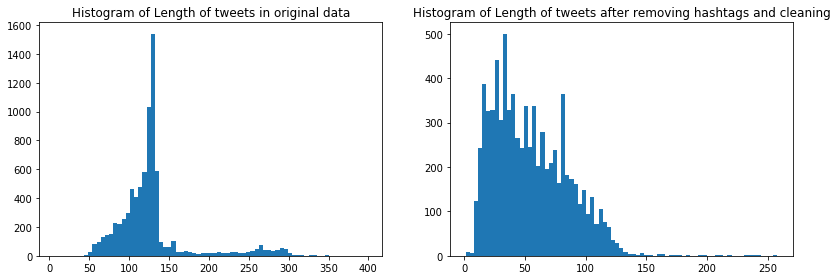

In [5]:
def see_changes(i):
    print('Original Tweet : \t', train_tweets[i])
    print('Original Label : \t', train_data.label[i])
    print('Extracted Hashtags : \t', train_hashtags[i])
    print('Preprocessed Tweet : \t' , train_cleaned_tweets[i])
    print()
    
for i in range(1002,1004):
    see_changes(i)
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].hist([len(x) for x in train_tweets], bins=75)
axes[0].set_title('Histogram of Length of tweets in original data')

axes[1].hist([len(x) for x in train_cleaned_tweets], bins=75)
axes[1].set_title('Histogram of Length of tweets after removing hashtags and cleaning')
fig.tight_layout()



### Analyse Hashtags
Histogram of number of hashtags in tweets

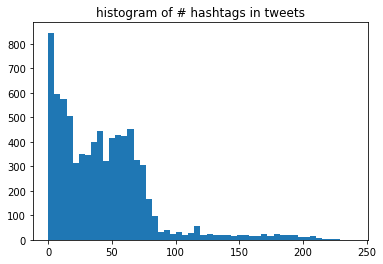

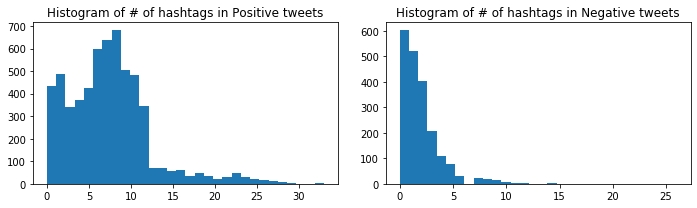

In [6]:
plt.hist([len(x) for x in train_hashtags], bins=50)
plt.title('histogram of # hashtags in tweets')

plt.show()


hashtags_count = [len(x.split()) for x in train_hashtags]
negative_hashtag_count = list(compress(hashtags_count, [x==1 for x in train_data.label]))
positive_hashtag_count = list(compress(hashtags_count, [x==0 for x in train_data.label]))


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axes[0].hist(positive_hashtag_count, bins=30)
axes[0].set_title('Histogram of # of hashtags in Positive tweets')
axes[1].hist(negative_hashtag_count, bins=30)
axes[1].set_title('Histogram of # of hashtags in Negative tweets')
fig.tight_layout()

In [7]:
mean_positive = sum(positive_hashtag_count) / len(positive_hashtag_count)
mean_negative = sum(negative_hashtag_count) / len(negative_hashtag_count)
print("Mean of number of hashtags in Tweets with positive sentiments: ", mean_positive)
print("Mean of number of hashtags in Tweets with negative sentiments: ", mean_negative)

Mean of number of hashtags in Tweets with positive sentiments:  7.336952833389888
Mean of number of hashtags in Tweets with negative sentiments:  1.7877591312931886


```
Interesting finding:
Positive tweets have a much much higher frequency of hashtags
```

### We extract features from the hashtag ans sequences using count tokenizer 

In [8]:
train_HT_features, test_HT_features = get_hashtags_features(train_hashtags, test_hashtags)
train_seq_features, test_seq_features = get_sequence_features(train_cleaned_tweets, test_cleaned_tweets, vocab_size=5000, mode='tfidf')

print("Shape of hashtags features:", train_HT_features.shape)
print("Shape of sequence features:", train_seq_features.shape)

type(train_HT_features)

Shape of hashtags features: (7920, 3500)
Shape of sequence features: (7920, 5000)


numpy.ndarray

## XGBOOST

In [9]:

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

train_features = np.c_[train_seq_features, train_HT_features]
test_features = np.c_[test_seq_features, test_HT_features]

x_train, x_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.01)

dtrain = xgb.DMatrix(data=x_train, label=y_train)
dval = xgb.DMatrix(data=x_val)
dtest = xgb.DMatrix(data=test_features)


params = {
    'booster':'gbtree',
    'max_depth': 9,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    # 'objective' : 'multi:softprob',
    'eval_metric' : 'mlogloss',
    'num_class': 2,
    'verbosity':0,
    'n_estimator':1000,
    # 'tree_method':'gpu_hist'
}

bst = xgb.train(params, dtrain)

val_predictions_ = bst.predict(dval)
test_predictions_ = bst.predict(dtest)  

val_accuracy = accuracy_score(val_predictions_, y_val)
print(val_accuracy)


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.8625


In [10]:
get_submission_csv(test_predictions_)

## dEEP NN

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_features (InputLayer) (None, 20)           0                                            
__________________________________________________________________________________________________
sequence_embeddings (Embedding) (None, 20, 16)       80000       input_seq_features[0][0]         
__________________________________________________________________________________________________
input_hashtag_features (InputLa (None, 3500)         0                                            
__________________________________________________________________________________________________
seq_LSTM_1 (LSTM)               (None, 20, 16)       2112        sequence_embeddings[0][0]        
____________________________________________________________________________________________

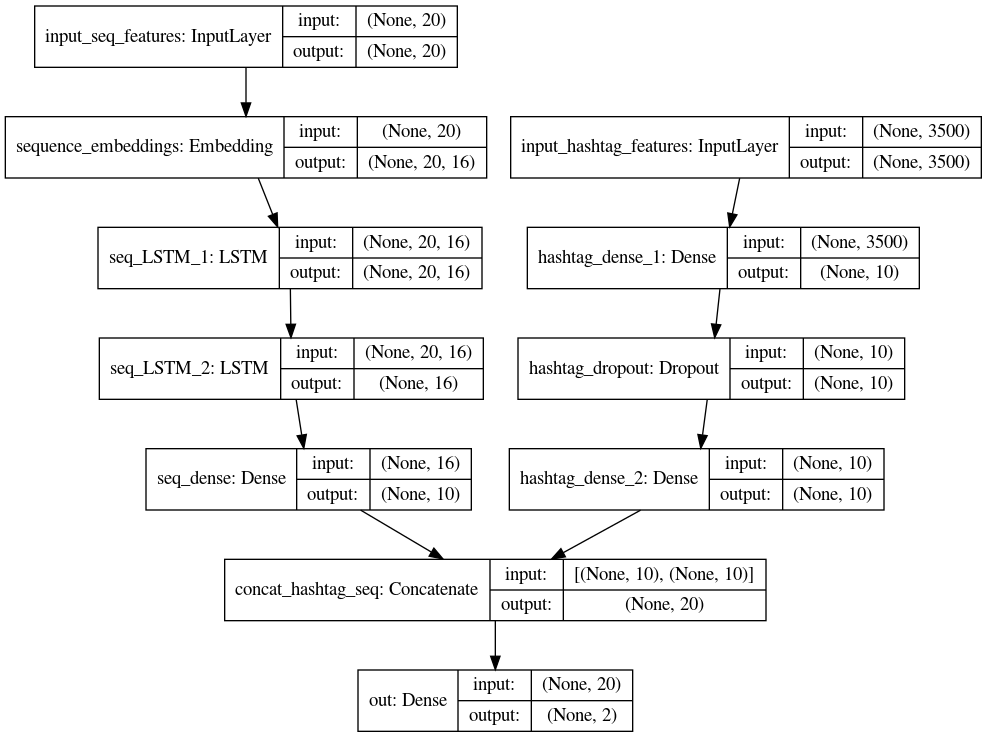

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Dropout, Input
from keras.layers import concatenate
from tensorflow.nn import leaky_relu


VOCAB_SIZE = 5000
HT_VEC_DIM = 3500

SEQ_DENSE_UNITS = 10
HT_DENSE_UNITS = 10

BATCH_SIZE = 16
EPOCHS = 8

OPTIMIZER = keras.optimizers.Adadelta()
LOSS = 'categorical_crossentropy'

# TUNED PARAMS
MAX_LEN_SEQ = 20
EMBEDDING_DIM = 16
LSTM_UNITS = 16
LSTM_DO = 0.2
RECURRENT_DO = 0.2
SEQ_DENSE_ACTIVATION = leaky_relu
HT_DENSE_DO = 0.2
HT_DENSE_ACTIVATION = leaky_relu
OPTIMIZER = 'adadelta'
EPOCHS = 2


train_HT_features, test_HT_features = get_hashtags_features(train_hashtags, test_hashtags, num_words=HT_VEC_DIM)
train_sequences, test_sequences = get_sequence_features_DL(train_cleaned_tweets, test_cleaned_tweets, max_len_seq=MAX_LEN_SEQ, vocab_size=VOCAB_SIZE)

input_seq = Input(shape=(MAX_LEN_SEQ,), name='input_seq_features')
x1 = Embedding(output_dim=EMBEDDING_DIM, input_dim=VOCAB_SIZE, input_length=MAX_LEN_SEQ, name='sequence_embeddings')(input_seq)
x1 = LSTM(LSTM_UNITS, dropout=LSTM_DO, recurrent_dropout=RECURRENT_DO, return_sequences=True, name='seq_LSTM_1')(x1)
x1 = LSTM(LSTM_UNITS, dropout=LSTM_DO, recurrent_dropout=RECURRENT_DO, name='seq_LSTM_2')(x1)
x1 = Dense(SEQ_DENSE_UNITS, activation=SEQ_DENSE_ACTIVATION, name='seq_dense')(x1)


input_HT = Input(shape=(HT_VEC_DIM,), name='input_hashtag_features')
x2 = Dense(HT_DENSE_UNITS, activation=HT_DENSE_ACTIVATION, name='hashtag_dense_1')(input_HT)
x2 = Dropout(HT_DENSE_DO, name='hashtag_dropout')(x2)
x2 = Dense(HT_DENSE_UNITS, activation=HT_DENSE_ACTIVATION, name='hashtag_dense_2')(x2)

x = concatenate([x1, x2], name='concat_hashtag_seq')
out = Dense(2, activation='sigmoid', name='out')(x)

DL_MODEL = Model(inputs=[input_seq, input_HT], outputs=out)

DL_MODEL.compile(OPTIMIZER, LOSS, metrics=['accuracy'])




DL_MODEL.summary()


from keras.utils import plot_model
plot_model(DL_MODEL, show_shapes=True, show_layer_names=True, to_file='model.png')

In [12]:
history = DL_MODEL.fit({'input_hashtag_features': train_HT_features, 'input_seq_features': train_sequences},
                {'out': train_labels_cat}, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.15)


# Train on all data
history = DL_MODEL.fit( {'input_hashtag_features': train_HT_features, 'input_seq_features': train_sequences},
                        {'out': train_labels_cat}, epochs=EPOCHS, batch_size=BATCH_SIZE,)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6732 samples, validate on 1188 samples
Epoch 1/2
6732/6732 [==============================] - 11s 2ms/step - loss: 0.3533 - accuracy: 0.8402 - val_loss: 0.2595 - val_accuracy: 0.8847
Epoch 2/2
6732/6732 [==============================] - 9s 1ms/step - loss: 0.2640 - accuracy: 0.8911 - val_loss: 0.2427 - val_accuracy: 0.8981
Epoch 1/2
7920/7920 [==============================] - 10s 1ms/step - loss: 0.2404 - accuracy: 0.8982
Epoch 2/2
7920/7920 [==============================] - 10s 1ms/step - loss: 0.2196 - accuracy: 0.9107


In [14]:

y_probs = DL_MODEL.predict({'input_hashtag_features': test_HT_features, 'input_seq_features': test_sequences})
y_preds = []
for i in y_probs:
    if(i[0]>i[1]): y_preds.append(0)
    else: y_preds.append(1)

get_submission_csv(y_preds)